In [117]:
# 1 - DATA MANIPULATION
import pandas as pd
import numpy as np

# 2 - DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# 3 - DATA EXPLORATION
from ydata_profiling import ProfileReport

# 4 - FEATURE ENGINEERING AND PREPROCESSING
import string #punctuation
import textstat

import nltk #English language stopwords
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.constraints import MaxNorm

import spacy
nlp = spacy.load("en_core_web_sm")

from lexicalrichness import LexicalRichness

import re

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.regularizers import l1, l2, l1_l2


# 5 - MODEL
#SKLEARN METRICS
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline



from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import models
from tensorflow.keras.utils import plot_model


In [118]:
import tensorflow as tf
print(tf.test.gpu_device_name())


/device:GPU:0


2023-12-07 18:48:08.368126: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-07 18:48:08.368195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [119]:
# Check tensorflow metal:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [120]:
# gpu is slower for this challenge
# Disable GPUs:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


In [121]:
df = pd.read_csv('/Users/andreacalcagni/code/AndreaCalcagni/neuroCraft/raw_data/CLEAR Corpus 6.01 - CLEAR Corpus 6.01.csv')


In [122]:
df = df.drop(columns=['Last Changed', 'URL', 'Anthology', 'MPAA \n#Max', 'Pub Year', 'MPAA\n#Avg', 'License', 'British Words', 'firstPlace_pred', 'secondPlace_pred', 'thirdPlace_pred',
       'fourthPlace_pred', 'fifthPlace_pred', 'sixthPlace_pred', 'ID', 'Author', 'Title', 'Source', 'Category', 'Location', 'MPAA\nMax', 'BT s.e.', 'Kaggle split'])


# 1. Feature Engineering

## 1.1 Text-Based Features

### 1.1.1. Word Count

In [123]:
def avg_word_count(row):
    return row[['Joon\nWC v1', 'Google\nWC']].mean()

# Create a new column
df['Avg Word Count'] = df.apply(avg_word_count, axis=1)
df = df.drop(columns=['Joon\nWC v1', 'Google\nWC'])


### 1.1.2 Unique Word Count

In [124]:
def count_unique_words(row):
    words = row['Excerpt'].split()
    return len(set(words))

df['Unique Word Count'] = df.apply(count_unique_words, axis=1)


### 1.1.3 Word Lenght

In [125]:
def avg_word_length(x):
    punctuation = string.punctuation
    for punc in punctuation:
        x = x.replace(punc,' ')
    words = x.split(' ')
    words = [word for word in words if len(word) > 0]
    word_len = [len(word) for word in words]
    return np.mean(word_len)

# New column 'Avg Word Length'
df['Avg Word Length'] = df['Excerpt'].apply(avg_word_length)


### 1.1.4 Sentence Count

In [126]:
def calculate_average_sentence_count(row):
    sentence_count_columns = ['Sentence\nCount v1', 'Sentence\nCount v2']
    return row[sentence_count_columns].mean()

# new column
df['Average Sentence Count'] = df.apply(calculate_average_sentence_count, axis=1)
df= df.drop(columns=['Sentence\nCount v1', 'Sentence\nCount v2'])


## 1.2 Complexity Features

### 1.2.1 Average Syllaba per Word

In [127]:
def avg_syllaba_word(x):
    syll_count = [textstat.syllable_count(word) for word in x.split()]
    return np.mean(syll_count)

df['Avg Syllables Per Word'] = df['Excerpt'].apply(avg_syllaba_word)


### 1.2.2 Avg Vowels per Word

In [128]:
def count_vowels(word):
    vowels = set("AEIOUaeiou")
    return sum(1 for char in word if char in vowels)

# New columns:
df['Avg Vowel Count Per Word'] = df['Excerpt'].apply(lambda x: np.mean([count_vowels(word) for word in x.split()]) if x else 0)
df['Total Vowels Per Excerpt'] = df['Excerpt'].apply(lambda x: sum(count_vowels(word) for word in x.split()) if x else 0)
df['Avg Vowels Per Excerpt'] = df['Total Vowels Per Excerpt']/df['Avg Word Count']
df = df.drop(columns=['Total Vowels Per Excerpt'])


### 1.2.3 Punctuation Ratio

In [129]:
def count_punctuation(x):
    punc = string.punctuation
    count=0

    for char in x:
        if char in punc:
            count+=1

    return count/ len(x)

df['punctuation_ratio'] = df['Excerpt'].apply(count_punctuation)


## 1.3 Structural Features

### 1.3.1 Average Sentence Lenght

In [130]:
def count_characters_per_sentence(excerpt):
    # Tokenize the text into sentences
    sentences = sent_tokenize(excerpt)

    # Count the number of characters in each sentence
    char_counts_per_sentence = [len(sentence) for sentence in sentences]

    return char_counts_per_sentence

df['Characters Per Sentence'] = df['Excerpt'].apply(count_characters_per_sentence)

def avg_chars_per_sentence(row):
    # Sum of character counts in all sentences
    total_chars = sum(row['Characters Per Sentence'])

    # Sum of sentence counts from both columns
    total_sentences = row['Average Sentence Count']

    # Calculate average characters per sentence
    return total_chars / total_sentences if total_sentences > 0 else 0

df['Avg Characters per Sentence'] = df.apply(avg_chars_per_sentence, axis=1)
df = df.drop(columns=['Characters Per Sentence'])


### 1.3.2 Ratio of Capital Letters

In [131]:
def ratio_capital_chars(excerpt):
    count = 0
    for char in excerpt:
        if char.isupper():
            count += 1
    return count/len(excerpt)

# new column
df['Capital Char Count'] = df['Excerpt'].apply(ratio_capital_chars)


In [132]:
def count_capital_words(excerpt):
    return sum(1 for word in excerpt.split() if word.isupper() and word.isalpha())

# new column
df['Capital Word Count'] = df['Excerpt'].apply(count_capital_words)
df['Ratio_capital_words'] = df['Capital Word Count']/df['Avg Word Count']
df = df.drop(columns=['Capital Word Count'])


## 1.4 Statistical Features

### 1.4.1 Std of Word Lenght

In [133]:
def word_length_std(excerpt):
    word_lengths = [len(word) for word in excerpt.split()]
    return np.std(word_lengths) if len(word_lengths) > 0 else 0

# New column 'Word Length Std'
df['Word Length Std'] = df['Excerpt'].apply(word_length_std)


### 1.4.2 Std of Sentence Lenght

In [134]:
def sentence_length_variation(row):
    sentence_lengths = count_characters_per_sentence(row['Excerpt'])
    return np.std(sentence_lengths)

df['Sentence Length Variation'] = df.apply(sentence_length_variation, axis=1)


## 1.5 Syntactic Complexity Features (NLP approach)

### 1.5.1 Avg sentence len in words

In [135]:
def sentence_len(x):

    x = x.replace("?",'.').replace("!",'.')

    sentences = x.split('.')

    sentences = [sentence for sentence in sentences if len(sentence) > 0]

    sent_len = [len(sentence.split()) for sentence in sentences]

    return np.mean(sent_len)

df['avg_sentence_len_words'] = df['Excerpt'].apply(sentence_len)


### 1.5.2 Number of clauses per sentence

In [136]:
# Function to calculate the number of clauses per sentence

# # Function to perform POS tagging and count occurrences of each POS
# def pos_distribution(excerpt):
#     # Parse the text using spaCy
#     doc = nlp(excerpt)
#     # Count the occurrences of each POS
#     pos_counts = Counter(token.pos_ for token in doc)
#     return pos_counts


# # Apply functions to create new columns
# df['Num Clauses Per Sentence'] = df['Excerpt'].apply(num_clauses_per_sentence_nlp)

# df['POS Distribution'] = df['Excerpt'].apply(pos_distribution)


In [137]:
# Function to calculate the number of clauses per sentence
# def num_clauses_per_sentence_nlp(excerpt):
#     # Parse the text using spaCy
#     doc = nlp(excerpt)
#     # Count the number of clauses (sentences) in the parsed document
#     num_clauses = len(list(doc.sents))
#     return num_clauses

# df['Num Clauses Per Sentence'] = df['Excerpt'].apply(num_clauses_per_sentence_nlp)


## 1.6 Lexical Diversity

In [138]:
def add_lexical_richness_features(df):
    cttr_list, msttr_list, mtld_list, yule_k_list = [], [], [], []

    for text in df['Excerpt']:
        lex = LexicalRichness(text)
        cttr_list.append(lex.cttr)
        msttr_list.append(lex.msttr(segment_window=25))  # Adjust the segment_window as needed
        mtld_list.append(lex.mtld(threshold=0.72))  # Adjust the threshold as needed
        yule_k_list.append(lex.yulek)

    df['cttr'] = cttr_list
    df['msttr'] = msttr_list
    df['mtld'] = mtld_list
    df['yule_k'] = yule_k_list

# Add lexical richness features to the DataFrame
add_lexical_richness_features(df)


In [139]:
# lexical_columns = ['cttr', 'msttr', 'mtld', 'yule_k']

# # new DataFrame with only the selected columns
# lexical_df = df[lexical_columns]

# # Calculate the correlation matrix
# correlation_matrix = lexical_df.corr()

# # Plot a heatmap of the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title("Correlation Matrix of Lexical Richness Features")
# plt.show()


# 2. Discretizing Target

In [140]:
# Calculating quantiles for bin edges - 7 edges for 6 bins
# quantiles = df['BT Easiness'].quantile([0, 0.1667, 0.3333, 0.5, 0.6667, 0.8333, 1]).tolist()

quantiles = df['BT Easiness'].quantile([0, 0.3333, 0.6667, 1]).tolist()


In [141]:
# Correct number of labels for 6 bins
labels_dict = {'hard':0, 'acceptable':1, 'easy':2}

# Using 'quantiles' for bins and including 6 labels
df['BT Easiness'] = pd.cut(
    x=df['BT Easiness'],
    bins=quantiles,
    labels=labels_dict.values(),
    include_lowest=True
)


# 3. Train Test Split

In [142]:
X = df.drop(columns=['BT Easiness'])
y = df['BT Easiness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 4. Dummy Baseline Model

In [143]:
y_pred = y_train.value_counts().idxmax()
y_pred = np.full(y_test.shape, y_pred)

accuracy_baseline = accuracy_score(y_test, y_pred)
accuracy_baseline


0.3164021164021164

# 5. NLP Model

## 5.1 Text Preprocessing

In [144]:
X_train_text = X_train['Excerpt'].values
X_test_text = X_test['Excerpt'].values


### 5.1.1 Basic Cleaning

In [145]:
def basic_cleaning(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())

    # Adding special quotes to the regular expression pattern
    special_quotes = '“”‘’'
    pattern = '[' + re.escape(string.punctuation + special_quotes) + ']'

    sentence = re.sub(pattern, '', sentence)
    sentence = sentence.strip()

    return sentence


In [146]:
X_train_text = [basic_cleaning(sentence) for sentence in X_train_text]
X_test_text = [basic_cleaning(sentence) for sentence in X_test_text]


### 5.1.2 Tokenizing

In [147]:
# def tokenizer(sentence):
#     return text_to_word_sequence(sentence)


In [148]:
# #tokenizing
# X_train_text = [tokenizer(sentence) for sentence in X_train_text]
# X_test_text = [tokenizer(sentence) for sentence in X_test_text]


### 5.1.3 Lemmatizing

In [149]:
# def lemmatizer(sentence):
#     wnl = WordNetLemmatizer()
#     verbs_lemmatized = []
#     for word in sentence:
#         verbs_lemmatized.append(wnl.lemmatize(word, pos = 'v'))
#     nouns_lemmatized = []
#     for word in verbs_lemmatized:
#         nouns_lemmatized.append(wnl.lemmatize(word, pos = 'n'))
#     adverbs_lemmatized = []
#     for word in nouns_lemmatized:
#         adverbs_lemmatized.append(wnl.lemmatize(word, pos = 'r'))
#     adj_lemmatized = []
#     for word in adverbs_lemmatized:
#         adj_lemmatized.append(wnl.lemmatize(word, pos = 'a'))
#     sat_lemmatized = []
#     for word in adj_lemmatized:
#         sat_lemmatized.append(wnl.lemmatize(word, pos = 'a'))
#     return sat_lemmatized


In [150]:
# X_train_text = [lemmatizer(sentence) for sentence in X_train_text]
# X_test_text = [lemmatizer(sentence) for sentence in X_test_text]


### 5.1.4 Removing Stopwords

In [151]:
# def removing_stopwords(sentence):
#     stop_words = set(stopwords.words('english'))
#     sentence_new = [w for w in sentence if not w in stop_words]
#     return sentence_new

# X_train_text = [removing_stopwords(sentence) for sentence in X_train_text]
# X_test_text = [removing_stopwords(sentence) for sentence in X_test_text]


### 5.1.5 Creating Embeddings

In [152]:
def create_embeddings(excerpts, model_name="roberta-base", max_length=190):
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="right")
    model = TFAutoModel.from_pretrained(model_name, from_pt=True)

    # Tokenize all excerpts at once
    tokenized_excerpts = tokenizer(excerpts, max_length=max_length, padding="max_length", truncation=True, return_tensors="tf")

    # Generate embeddings in a batch
    embeddings = model.predict(tokenized_excerpts["input_ids"])

    return embeddings.last_hidden_state#[:,0,:]

# Assuming X_train_text and X_test_text are lists of sentences/excerpts
with tf.device('GPU:0'):  # Change to '/CPU:0' if you want to use CPU
    X_train_text = create_embeddings(X_train_text)
    X_test_text = create_embeddings(X_test_text)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


119/119 [==============================] - 331s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


30/30 [==============================] - 84s 3s/step


In [153]:
X_train_text.shape


(3779, 190, 768)

## 5.2 Model Training

In [154]:
# def build_model_nlp():
#     model = Sequential([
#         # layers.Conv1D(105, kernel_size=15, padding='same', activation="relu", input_shape=X_train_pad.shape[1:]),
#         # layers.Conv1D(64, kernel_size=10, padding='same', activation="relu"),
#         # layers.Flatten(),
#         #layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=X_train_text.shape[1:]),
#         #layers.Bidirectional(layers.LSTM(64), input_shape=(512,)),
#         #layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(512,)),
#         layers.Bidirectional(layers.LSTM(64, kernel_constraint=MaxNorm(3)), input_shape=X_train_text.shape[1:]),
#         layers.Dropout(0.3),
#         layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
#         layers.Dropout(0.3),
#         layers.Dense(4, activation='softmax'),
#     ])

#     model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
#     return model

# model_nlp = build_model_nlp()
# model_nlp.summary()


In [155]:
# es = EarlyStopping(patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# model_nlp = build_model_nlp()
# with tf.device('GPU:0'):
#     model_nlp.fit(X_train_text, y_train,
#             validation_split=0.3,
#             epochs=50,
#             batch_size=32,
#             callbacks=[es, reduce_lr]
#             )


In [ ]:
def build_model_nlp(compile=False, combine=True):
    input_nlp = layers.Input(shape=X_train_text.shape[1:])
    x = layers.Bidirectional(layers.LSTM(32, kernel_constraint=MaxNorm(3), return_sequences=True, kernel_regularizer=l2(0.01)))(input_nlp)
    x = layers.Dropout(0.5)(x)
    x = layers.Bidirectional(layers.LSTM(16, kernel_constraint=MaxNorm(3), kernel_regularizer=l2(0.01)))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(16, activation="relu", kernel_regularizer=l1_l2(l1=0.001, l2=0.01))(x)
    x = layers.Dropout(0.5)(x)

    output_nlp = layers.Dense(16, activation="relu")(x)

    if combine==False:
        output_nlp = layers.Dense(3, activation="softmax")(output_nlp)


    model_nlp = models.Model(inputs=input_num, outputs=output_num)

    if compile:
        model_nlp.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model_nlp

model_nlp = build_model_num(compile=True, combine=False)
model_nlp.summary()


In [156]:
# def build_model_nlp():
#     model = Sequential([
#         layers.Bidirectional(layers.LSTM(32, kernel_constraint=MaxNorm(3), return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=X_train_text.shape[1:]),
#         layers.Dropout(0.5),
#         layers.Bidirectional(LSTM(16, kernel_regularizer=l2(0.01))),
#         layers.Dropout(0.4),
#         layers.Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01)),
#         layers.Dropout(0.5),
#         layers.Dense(3, activation='softmax')
#     ])

#     model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
#     return model

# Custom learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Callbacks
es = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
lr_scheduler = LearningRateScheduler(scheduler)


model_nlp = build_model_nlp(compile=True, combine=False)
model_nlp.summary()

# Fit the model
with tf.device('GPU:0'):
    history = model_nlp.fit(
        X_train_text, y_train,
        validation_split=0.3,
        epochs=50,
        batch_size=32,
        callbacks=[es, reduce_lr, lr_scheduler]
    )

plot_history(history)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 190, 64)           205056    
 onal)                                                           
                                                                 
 dropout_172 (Dropout)       (None, 190, 64)           0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_173 (Dropout)       (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                                 
 dropout_174 (Dropout)       (None, 16)               

## 5.3 Model Evaluation

In [157]:
loss, accuracy = model_nlp.evaluate(X_test_text, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


30/30 [==============================] - 1s 43ms/step - loss: 0.7608 - accuracy: 0.7048
Test loss: 0.7608
Test accuracy: 0.7048


In [158]:
predictions = model_nlp.predict(X_test_text)

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)


30/30 [==============================] - 2s 42ms/step


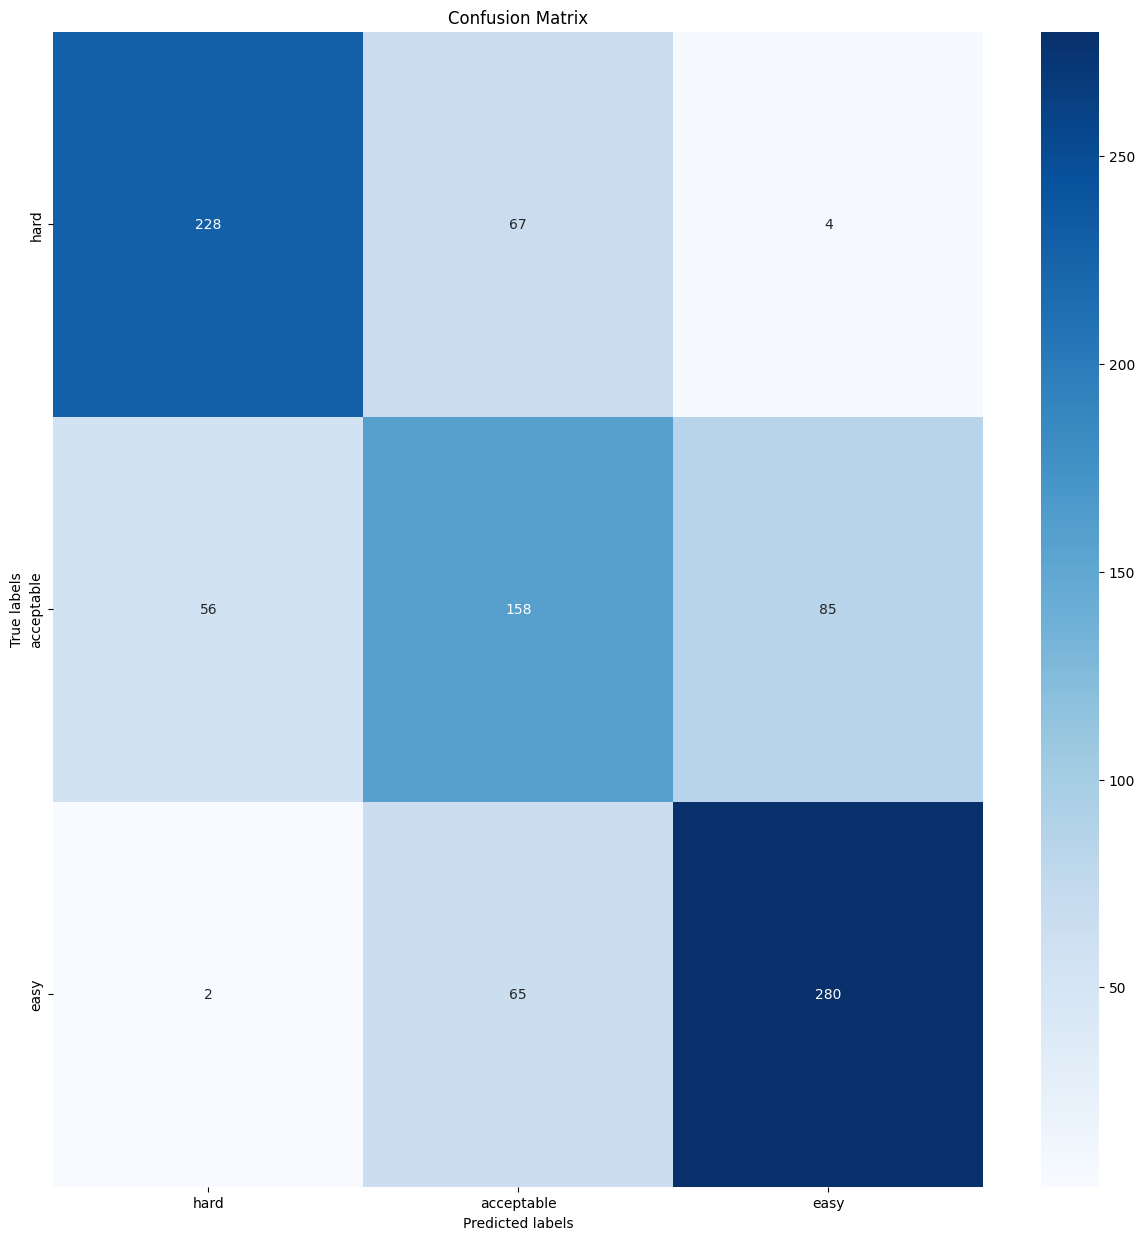

In [159]:
y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


In [179]:
df['Excerpt'].iloc[3]


"Mr. Grimes was to come up next morning to Sir John Harthover's, at the Place, for his old chimney-sweep was gone to prison, and the chimneys wanted sweeping. And so he rode away, not giving Tom time to ask what the sweep had gone to prison for, which was a matter of interest to Tom, as he had been in prison once or twice himself. Moreover, the groom looked so very neat and clean, with his drab gaiters, drab breeches, drab jacket, snow-white tie with a smart pin in it, and clean round ruddy face, that Tom was offended and disgusted at his appearance, and considered him a stuck-up fellow, who gave himself airs because he wore smart clothes, and other people paid for them; and went behind the wall to fetch the half-brick after all; but did not, remembering that he had come in the way of business, and was, as it were, under a flag of truce."

In [180]:
simplified = "Mr. Grimes was going to Sir John Harthover's place the next morning to sweep the chimneys because their usual chimney sweep was in jail. He left quickly, so Tom couldn't ask why the sweep was in jail, which interested Tom since he had been in jail a few times too. Tom saw the groom, who looked very neat and clean in his drab clothes and white tie with a fancy pin, and had a round, red face. Tom felt jealous and thought the groom was showing off just because he wore nice clothes paid for by others. Tom wanted to throw a brick at him, but he didn't because he was there for work, which was like being in a truce."


In [181]:
simplified_embedding = create_embeddings(simplified)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


1/1 [==============================] - 2s 2s/step


In [185]:
predicted_text = model_nlp.predict(simplified_embedding)

# Convert probabilities to class labels
predicted_text = np.argmax(predicted_text, axis=1)
predicted_text


1/1 [==============================] - 0s 25ms/step


array([2])

# 6. Model with numerical features

In [160]:
X_train_num = X_train.drop(columns=['Excerpt'])
X_test_num = X_test.drop(columns=['Excerpt'])


## 6.1 Preprocessing

### 6.1.1 Scaling

In [161]:
scaler = StandardScaler()
scaler.fit(X_train_num)
X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)


## 6.2 Model Training

In [ ]:
def build_model_num(compile=False, combine=True):
    input_num = layers.Input(shape=X_train_num.shape[1])

    x = layers.Dense(64, activation="relu")(input_num)
    x = layers.Dense(32, activation="relu")(x)
    output_num = layers.Dense(16, activation="relu")(x)

    if combine==False:
        output_num = layers.Dense(3, activation="softmax")(output_num)


    model_num = models.Model(inputs=input_num, outputs=output_num)

    if compile:
        model_num.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
    return model_num

model_num = build_model_num(compile=True, combine=False)
model_num.summary()


In [162]:
# def build_model_num():
#     model = Sequential([
#         layers.Dense(64, activation="relu", input_dim = X_train_num.shape[1]),
#         layers.Dropout(0.25),
#         layers.Dense(32, activation="relu"),
#         layers.Dropout(0.25),
#         layers.Dense(16, activation="relu"),
#         layers.Dropout(0.25),
#         layers.Dense(3, activation='softmax')
#     ])

#     model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
#     return model

# model_num = build_model_num()
# model_num.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 356)               10680     
                                                                 
 dropout_175 (Dropout)       (None, 356)               0         
                                                                 
 dense_39 (Dense)            (None, 128)               45696     
                                                                 
 dropout_176 (Dropout)       (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dropout_177 (Dropout)       (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 32)              

In [163]:
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model_num.fit(X_train_num, y_train,
          validation_split=0.3,
          epochs=50,
          batch_size=32,
          callbacks=[es]
          )
plot_history(history)


Epoch 1/50
83/83 [==============================] - 1s 3ms/step - loss: 0.9313 - accuracy: 0.5202 - val_loss: 0.8308 - val_accuracy: 0.5838
Epoch 2/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8568 - accuracy: 0.5913 - val_loss: 0.8049 - val_accuracy: 0.6041
Epoch 3/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8378 - accuracy: 0.5962 - val_loss: 0.8245 - val_accuracy: 0.5926
Epoch 4/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8300 - accuracy: 0.6087 - val_loss: 0.8056 - val_accuracy: 0.6023
Epoch 5/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8116 - accuracy: 0.6140 - val_loss: 0.7982 - val_accuracy: 0.6129
Epoch 6/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8104 - accuracy: 0.6095 - val_loss: 0.7878 - val_accuracy: 0.6182
Epoch 7/50
83/83 [==============================] - 0s 2ms/step - loss: 0.7927 - accuracy: 0.6174 - val_loss: 0.7830 - val_accuracy: 0.6199
Epoch 8/50
83/83 [==

## 6.3 Model Evaluation

In [164]:
loss, accuracy = model_num.evaluate(X_test_num, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


30/30 [==============================] - 0s 736us/step - loss: 0.7653 - accuracy: 0.6455
Test loss: 0.7653
Test accuracy: 0.6455


30/30 [==============================] - 0s 657us/step


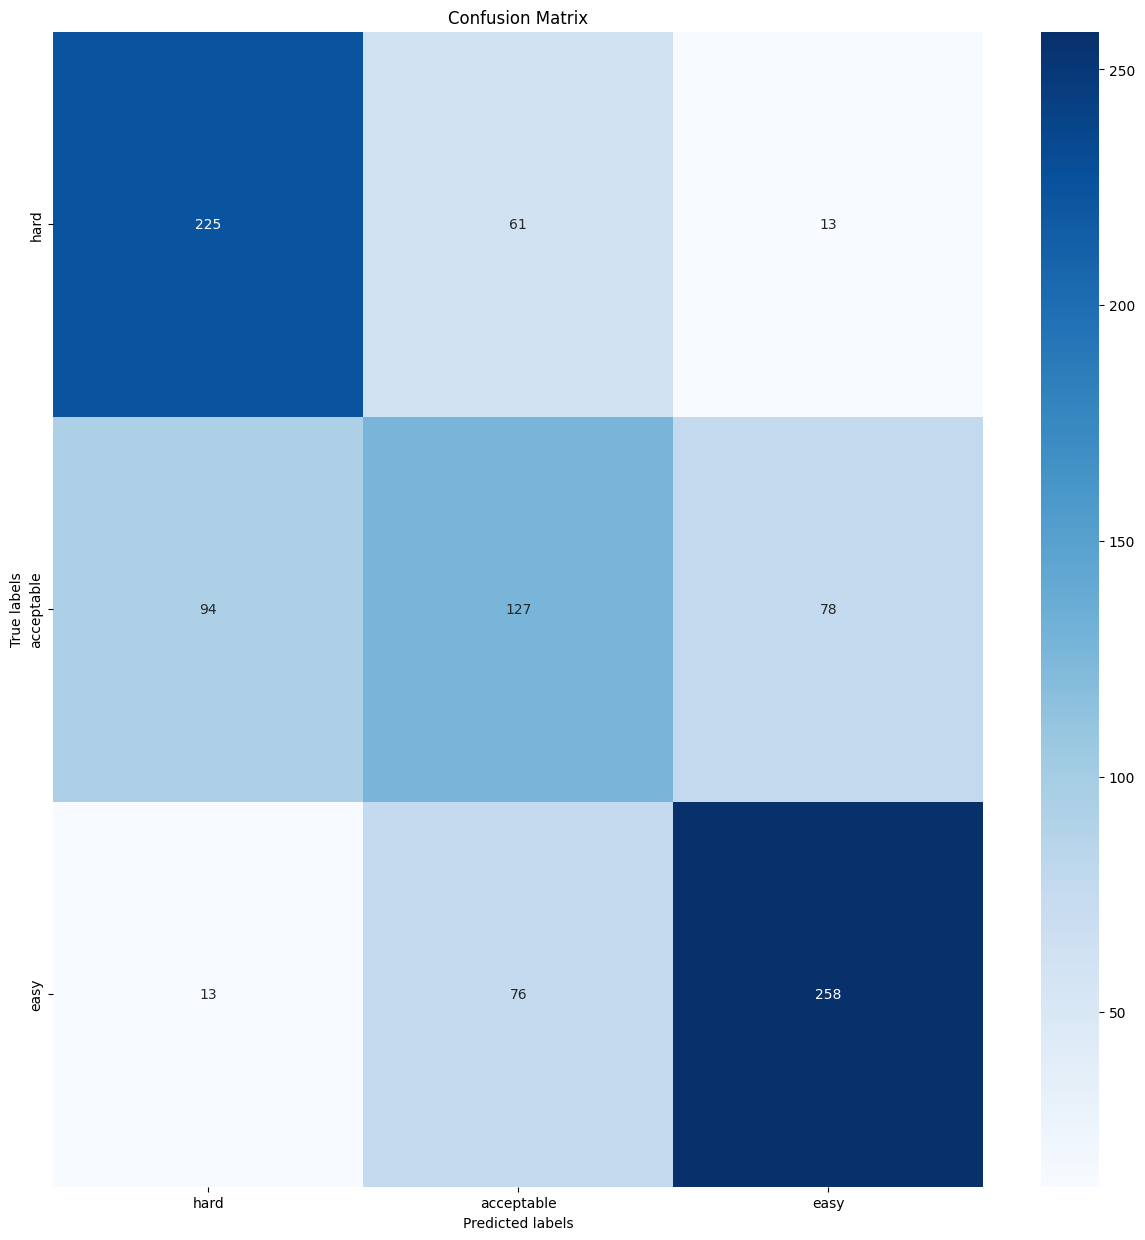

In [165]:
predictions = model_num.predict(X_test_num)

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)

y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


# 7. Combining the models

In [166]:
# Define Inputs and Outputs of NLP model as with Numeric Model
model_nlp = build_model_nlp() # comment-out to keep pre-trained weights not to start from scratch
input_text = model_nlp.input
output_text = model_nlp.output

model_num = build_model_num() # comment-out to keep pre-trained weights not to start from scratch
input_num = model_num.input
output_num = model_num.output


In [167]:
# Let's combine the two streams of data and add two dense layers on top!
inputs = [input_text, input_num]

combined = layers.concatenate([0.8*output_text, 0.2*output_num])

x = layers.Dense(32, activation="relu")(combined)
x = layers.Dropout(0.25)(x)
x = layers.Dense(16, activation="relu")(x)

outputs = layers.Dense(3, activation="softmax")(x)

model_combined = models.Model(inputs=inputs, outputs=outputs)


In [168]:
model_combined.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model_combined.fit(x=[X_train_text, X_train_num],
                   y=y_train,
                   validation_split=0.3,
                   epochs=100,
                   batch_size=32,
                   callbacks=[es])

plot_history(history)


Epoch 1/100
83/83 [==============================] - 17s 149ms/step - loss: 3.3091 - accuracy: 0.3633 - val_loss: 1.6098 - val_accuracy: 0.5741
Epoch 2/100
83/83 [==============================] - 11s 135ms/step - loss: 1.2970 - accuracy: 0.5369 - val_loss: 1.0611 - val_accuracy: 0.5829
Epoch 3/100
83/83 [==============================] - 11s 134ms/step - loss: 0.9961 - accuracy: 0.5656 - val_loss: 0.8910 - val_accuracy: 0.5952
Epoch 4/100
83/83 [==============================] - 11s 137ms/step - loss: 0.8971 - accuracy: 0.5868 - val_loss: 0.8384 - val_accuracy: 0.5996
Epoch 5/100
83/83 [==============================] - 11s 136ms/step - loss: 0.8534 - accuracy: 0.6076 - val_loss: 0.8060 - val_accuracy: 0.6182
Epoch 6/100
83/83 [==============================] - 11s 134ms/step - loss: 0.8354 - accuracy: 0.6087 - val_loss: 0.8046 - val_accuracy: 0.6190
Epoch 7/100
83/83 [==============================] - 11s 136ms/step - loss: 0.8297 - accuracy: 0.6189 - val_loss: 0.7891 - val_accuracy:

In [169]:
loss, accuracy = model_combined.evaluate([X_test_text, X_test_num], y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


30/30 [==============================] - 1s 46ms/step - loss: 0.7915 - accuracy: 0.6317
Test loss: 0.7915
Test accuracy: 0.6317


In [170]:
predictions = model_combined.predict([X_test_text, X_test_num])

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)


30/30 [==============================] - 2s 43ms/step


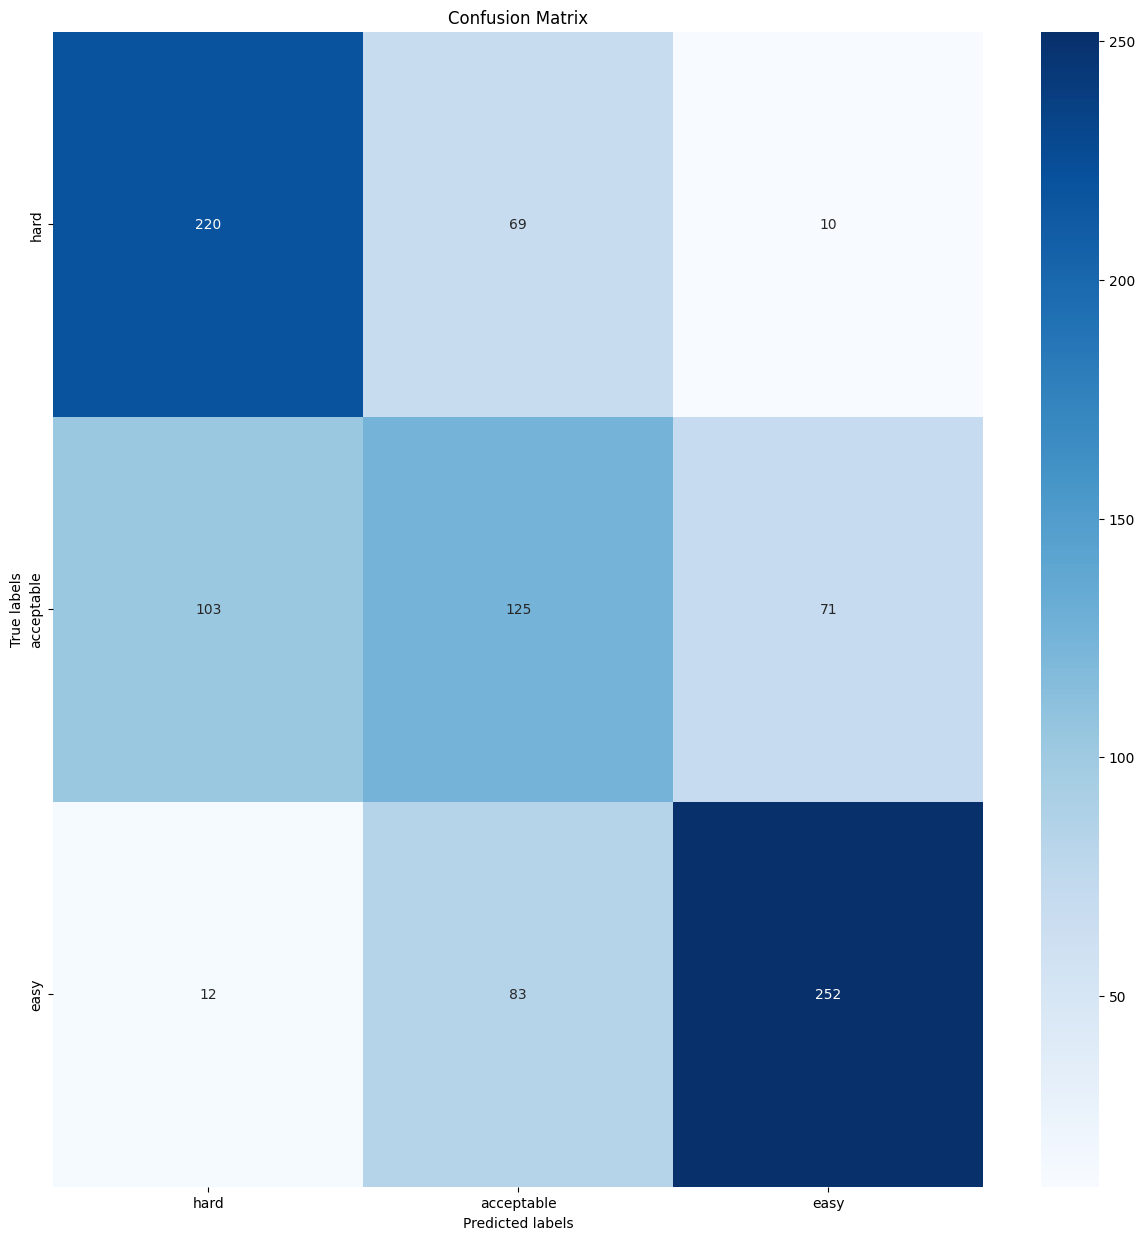

In [171]:
y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


In [172]:
df.columns


Index(['Excerpt', 'British WC', 'Paragraphs', 'BT Easiness',
       'Flesch-Reading-Ease', 'Flesch-Kincaid-Grade-Level',
       'Automated Readability Index', 'SMOG Readability',
       'New Dale-Chall Readability Formula', 'CAREC', 'CAREC_M', 'CARES',
       'CML2RI', 'Avg Word Count', 'Unique Word Count', 'Avg Word Length',
       'Average Sentence Count', 'Avg Syllables Per Word',
       'Avg Vowel Count Per Word', 'Avg Vowels Per Excerpt',
       'punctuation_ratio', 'Avg Characters per Sentence',
       'Capital Char Count', 'Ratio_capital_words', 'Word Length Std',
       'Sentence Length Variation', 'avg_sentence_len_words', 'cttr', 'msttr',
       'mtld', 'yule_k'],
      dtype='object')

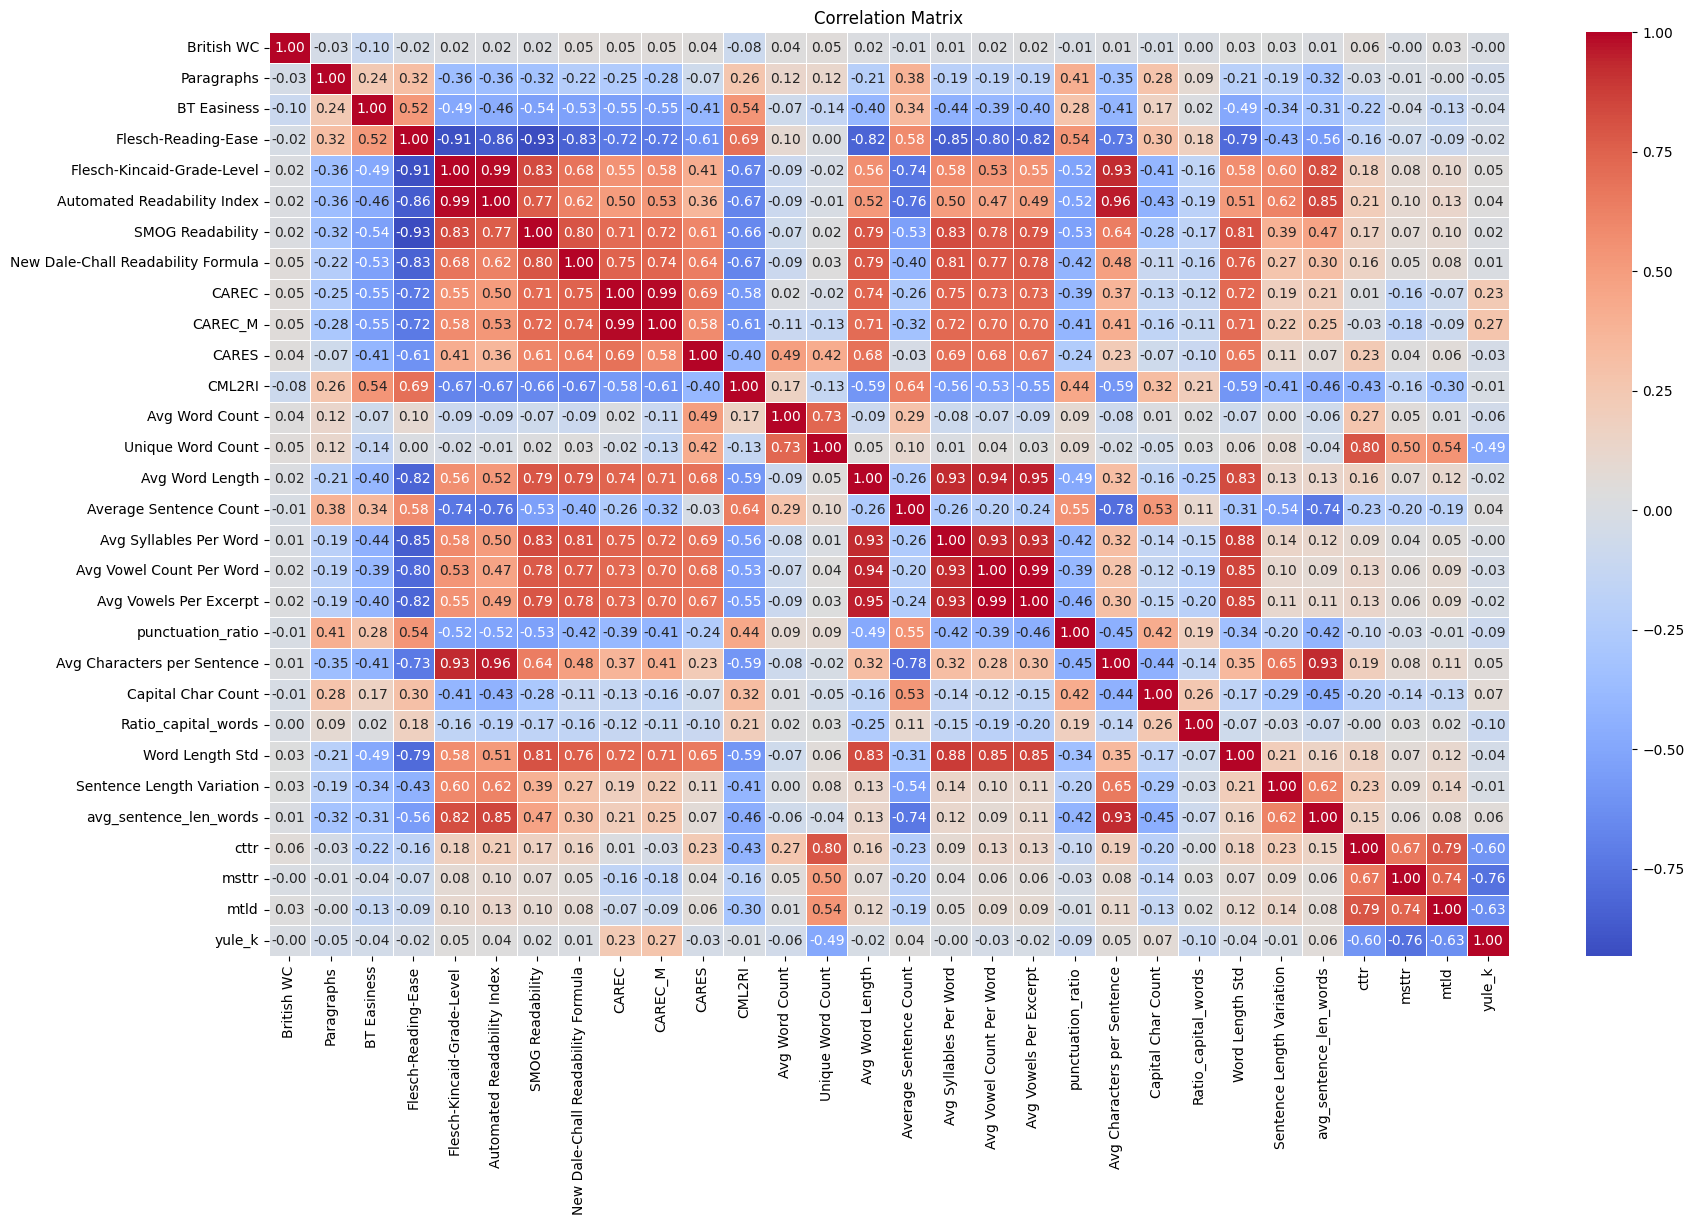

In [173]:
df_columns = df.columns
df_num = df.drop(columns=["Excerpt"])

# Calculate the correlation matrix
correlation_matrix = df_num.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()
